In [1]:
# Environment Variables: 

YES = 1
NO = 0

DATA_DIR = '/home/pujan/Research/RHEED/Data/' # Change to your DATA PATH

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import tensorflow as tf
from qkeras import *

In [3]:
# Read H5 Data File:
RHEED_data_file = DATA_DIR + 'RHEED_4848_test6.h5'
spot = 'spot_2'

h5 = h5py.File(RHEED_data_file, 'r')

raw_data = []
for growth in h5.keys():
    raw_data.extend(h5[growth][spot])
raw_data = np.array(raw_data).astype(np.float32)
raw_data = np.expand_dims(raw_data, axis=-1).astype(np.float32) # if (batch_size, height, width, channels)

print(f'[Raw Images Shape]: {raw_data.shape}')

[Raw Images Shape]: (150985, 48, 48, 1)


In [4]:
# Normalize w/ image max

normalized_images = []
normalized_factor = []
for image in tqdm(raw_data):
    normalized_images.append(image / (np.max(image) + 1))
    normalized_factor.append(np.max(image))
normalized_images = np.array(normalized_images).astype(np.float32)
normalized_factor = np.array(normalized_factor).astype(np.float32)

print(f'[Normalized Images Shape]: {normalized_images.shape}')

100%|██████████| 150985/150985 [00:02<00:00, 74397.15it/s]


[Normalized Images Shape]: (150985, 48, 48, 1)


In [5]:
# Clamp to 8 bits fractional
normalized_images_0I_8F = []
for image in tqdm(normalized_images):
    normalized_images_0I_8F.append(np.round(image * 256) / 256)
normalized_images_0I_8F = np.array(normalized_images_0I_8F).astype(np.float32)

print(f'[Normalized Images Shape]: {normalized_images_0I_8F.shape}')

100%|██████████| 150985/150985 [00:01<00:00, 147631.71it/s]


[Normalized Images Shape]: (150985, 48, 48, 1)


In [6]:
# Load Fitted Labels: 
RHEED_label_file = DATA_DIR + 'Estimated_Labels.npy'

estimated_labels = np.load(RHEED_label_file)

# Dirty Clipping, Need to spend some time on this
# estimated_labels[:, 0] = np.clip(estimated_labels[:, 0], 0, 48)
# estimated_labels[:, 1] = np.clip(estimated_labels[:, 1], 0, 48)
# estimated_labels[:, 2] = np.clip(estimated_labels[:, 2], 0, 24)
# estimated_labels[:, 3] = np.clip(estimated_labels[:, 3], 0, 24)
# estimated_labels[:, 4] = np.clip(estimated_labels[:, 4], -np.pi/2, np.pi/2)

print(f'[Orig Estimated Labels Shape]: {estimated_labels.shape}')

[Orig Estimated Labels Shape]: (150985, 5)


In [7]:
# Gaussian Functions: (TENSORFLOW)

# mean_x, mean_y, cov_x, cov_y, theta
def generate_guassian(batch, image_shape):
    batch_size = batch.shape[0]
    batch = tf.expand_dims(tf.expand_dims(batch, axis=-1), axis=-1)
    x0, y0, sigma_x, sigma_y, theta = tf.cast(tf.unstack(batch, axis=-3), tf.float32)
    
    x_range = tf.range(start=0, limit=image_shape[0], delta=1)
    y_range = tf.range(start=0, limit=image_shape[1], delta=1)
    X_coord, Y_coord = tf.meshgrid(x_range, y_range, indexing='xy')
    X_coord = tf.cast(tf.expand_dims(X_coord, axis=0), tf.float32)
    Y_coord = tf.cast(tf.expand_dims(Y_coord, axis=0), tf.float32)
    
    X_coord = tf.tile(X_coord, [batch_size, 1, 1])
    Y_coord = tf.tile(Y_coord, [batch_size, 1, 1])
    
    a = tf.math.pow(tf.math.cos(theta), 2) / (2 * tf.math.pow(sigma_x, 2)) + tf.math.pow(tf.math.sin(theta), 2) / (2 * tf.math.pow(sigma_y, 2))
    b = -1 * tf.math.sin(theta) * tf.math.cos(theta) / (2 * tf.math.pow(sigma_x, 2)) + tf.math.sin(theta) * tf.math.cos(theta) / (2 * tf.math.pow(sigma_y, 2))
    c = tf.math.pow(tf.math.sin(theta), 2) / (2 * tf.math.pow(sigma_x, 2)) + tf.math.pow(tf.math.cos(theta), 2) / (2 * tf.math.pow(sigma_y, 2))

    img = tf.exp(-1 * (a * (X_coord - x0) ** 2 + 2 * b * (X_coord - x0) * (Y_coord - y0) + c * (Y_coord - y0) ** 2))

    return tf.expand_dims(img, axis=-1) # if (batch_size, height, width, channels)
    return tf.expand_dims(img, axis=1)  # if (batch_size, channels, height, width)

def custom_weighted_mse_loss(I, J, n):
  W = tf.pow(I, n)

  squared_diffs = tf.pow(I - J, 2)

  weighted_squared_diffs = W * squared_diffs

  loss = tf.reduce_mean(weighted_squared_diffs)

  return loss

In [35]:
Model_file = DATA_DIR +'Models/[8]Gaussian_2I_6F.keras'
with tf.keras.utils.custom_object_scope({'custom_weighted_mse_loss': custom_weighted_mse_loss,
                                         'QConv2DBatchnorm': QConv2DBatchnorm,
                                         'QActivation': QActivation,
                                         'QDense': QDense
                                         }):
        model = tf.keras.models.load_model(Model_file)

/home/pujan/miniconda3/envs/RHEED/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [36]:
images_to_predict = 10000
scaling_arr = np.array([48.0, 48.0, 24.0, 24.0, np.pi/2]).astype(np.float32)

predicted_params = model.predict(normalized_images_0I_8F[: images_to_predict]) * scaling_arr
reconstructed_images = generate_guassian(predicted_params, (48,48))

313/313 [==============================] - 13s 36ms/step


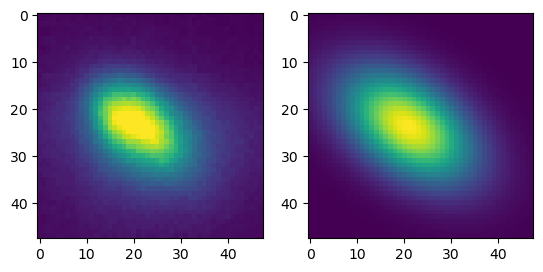

In [39]:
# View (MSE / MAE is not great because fitting is not great)
index = np.random.randint(low=0, high=images_to_predict)

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(normalized_images_0I_8F[index]))

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(reconstructed_images[index]))
